## Modeling: Metadata-Based Book Recommendations 

Suggest similar items to a particular item based on the metadata like genre, author, publication year, publisher, etc. for books. The general idea behind this method is that if a person liked a particular item, he or she will also like an item that is similar to it.
<br><br>In this type of recommender system the metadata available for a book is used to find its similarity with other books. Then the books that are most likely to be similar are recommended. Only publicly acclaimed books are suggested for better user experience.

### Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Visualization enhancement
Adjust plots size for better visualization experience.

In [2]:
plt.rcParams["figure.figsize"] = [25, 10]
plt.rcParams.update({'font.size': 24})

### Dataset
A dataset extraction where each row represents a new book will be used for modeling. In addition, the data frame shown below contains only popular publicly acclaimed books with rating above the average. Extracting these books from the main dataset can be observed in notebook *Statistics-PopularityBasedFiltering*.

In [3]:
df = pd.read_csv('PopularBooks.csv', error_bad_lines=False, delimiter=',', encoding = 'ISO-8859-1') 
df.head()

,Book-Title,Year-Of-Publication,Book-Author,AVG-Rating,Publisher,Vote-Count,ISBN,score
0,"The Two Towers (The Lord of the Rings, Part 2)",1999,J. R. R. Tolkien,9.320896,Houghton Mifflin Company,134,0345339711,8.983809
1,Harry Potter and the Goblet of Fire (Book 4),2002,J. K. Rowling,9.125506,Scholastic Paperbacks,247,0439139597,8.947356
2,Harry Potter and the Prisoner of Azkaban (Book 3),2001,J. K. Rowling,9.043321,Scholastic,277,0439136350,8.890978
3,Harry Potter and the Order of the Phoenix (Boo...,2003,J. K. Rowling,9.047393,Scholastic,211,043935806X,8.853137
4,"The Return of the King (The Lord of the Rings,...",1986,J.R.R. TOLKIEN,9.254902,Del Rey,102,0345339738,8.853077


In order to do this type of filtering, the following attributes are going to be used:
* Book-Title
* Book-Author
* Publication Year
* Publisher 

The lack of book summary and genre is a setback for this type of filtering. Therefore, for further deployment and development of such filtering, more features are necessary to be collected. For now, apply this type of recommender using the available books-related data just to have an initial version at disposal.

To prevent ambiguity, the attributes of type string will be modified by:
* removing spaces between names of authors so that the same author is considered when searching for similarities;
* removing spaces in the publishing agency name to achieve the result mentioned above;
* converting the words to lowercase.

In [4]:
# Function to sanitize data to prevent ambiguity. It removes spaces and converts to lowercase
def sanitize(x):
    return str.lower(x.replace(" ", ""))

In [5]:
# Apply the sanitize function to chosen string attributes: authors and publisher
for feature in ['Book-Author', 'Publisher']:
    df[feature] = df[feature].apply(sanitize)

# Convert book title to lowercase only
df.loc['Book-Title'] = df['Book-Title'].str.lower()

The modified attributes are now in the following format:

In [6]:
df[['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']].head()

,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,"The Two Towers (The Lord of the Rings, Part 2)",j.r.r.tolkien,1999.0,houghtonmifflincompany
1,Harry Potter and the Goblet of Fire (Book 4),j.k.rowling,2002.0,scholasticpaperbacks
2,Harry Potter and the Prisoner of Azkaban (Book 3),j.k.rowling,2001.0,scholastic
3,Harry Potter and the Order of the Phoenix (Boo...,j.k.rowling,2003.0,scholastic
4,"The Return of the King (The Lord of the Rings,...",j.r.r.tolkien,1986.0,delrey


In [7]:
df['Year-Of-Publication'] = df['Year-Of-Publication'].astype("string")
df['Book-Title'] = df['Book-Title'].astype("string")
df['Book-Author'] = df['Book-Author'].astype("string")
df['Publisher'] = df['Publisher'].astype("string")

To successfully execute metadata-based filtering, the following mixture of all 4 chosen features has to be created:

In [8]:
#Function that creates a soup out of the desired metadata
def create_soup(x):
    return x['Book-Title'] + ' ' + x['Book-Author'] + ' ' +x['Year-Of-Publication'] + ' ' + x['Publisher']

In [9]:
# Create the new soup feature
df['soup'] = df.apply(create_soup, axis=1)

In [10]:
df.iloc[0]['soup']

'The Two Towers (The Lord of the Rings, Part 2) j.r.r.tolkien 1999.0 houghtonmifflincompany'

This newly added attribute will be used as a basis for the aimed filtering.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 786 entries, 0 to Book-Title
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book-Title           785 non-null    string 
 1   Year-Of-Publication  785 non-null    string 
 2   Book-Author          785 non-null    string 
 3   AVG-Rating           785 non-null    float64
 4   Publisher            785 non-null    string 
 5   Vote-Count           785 non-null    float64
 6   ISBN                 785 non-null    object 
 7   score                785 non-null    float64
 8   soup                 785 non-null    object 
dtypes: float64(3), object(2), string(4)
memory usage: 61.4+ KB


It seems that there is 1 NaN value for each attribute. Retrieve this row:

In [12]:
df.loc[df['ISBN'].isnull()]

,Book-Title,Year-Of-Publication,Book-Author,AVG-Rating,Publisher,Vote-Count,ISBN,score,soup
Book-Title,<NA>,<NA>,<NA>,NaN,<NA>,NaN,NaN,NaN,<NA>


Remove the whole row as it is useless:

In [13]:
df = df[df.ISBN.notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 785 entries, 0 to 784
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Book-Title           785 non-null    string 
 1   Year-Of-Publication  785 non-null    string 
 2   Book-Author          785 non-null    string 
 3   AVG-Rating           785 non-null    float64
 4   Publisher            785 non-null    string 
 5   Vote-Count           785 non-null    float64
 6   ISBN                 785 non-null    object 
 7   score                785 non-null    float64
 8   soup                 785 non-null    object 
dtypes: float64(3), object(2), string(4)
memory usage: 61.3+ KB


A tool called *CountVectorizer* will be used to create vectors for the *soup* column. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. More weight is given to the words that are more repetitive. These vectors are the foundation of how the books suggestions will be retrieved later. In addition, some meaningless words (stop words) like prepositions, sentence-connecting words and others, will be skipped to increase similarity accuracy.

In [14]:
# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Define a new CountVectorizer object and create vectors for the soup
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df['soup'])

In [15]:
count_vect_df = pd.DataFrame(count_matrix.todense(), columns=count.get_feature_names())
count_vect_df

,12,13,14,15,1902,1953,1957,1959,1968,1969,...,yearlingbooks,years,young,zen,zero,zondervanpublishingcompany,zone,zooey,zoranealehurston,â¼bbe
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
781,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
782,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The count vectorizer matrix is created. The only thing left is measuring the similarity between each two books to find which have most common features. This will be done using *cosine similarity* metric that measures the similarity between two vectors. 


**The closer the cosine value to 1, the smaller the angle and the greater the match between vectors.**

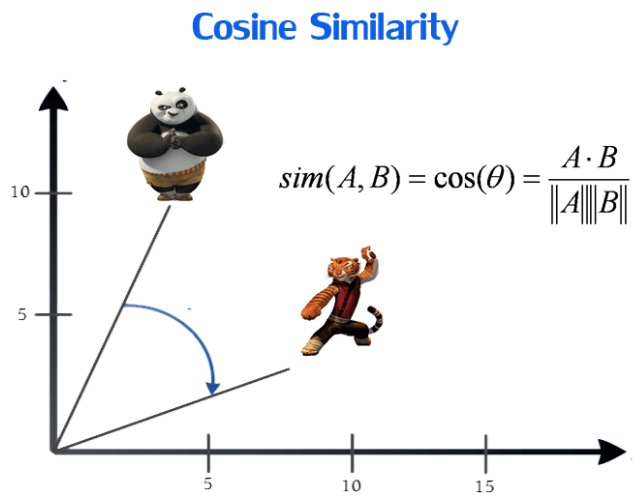

In [16]:
from IPython import display
display.Image("https://goodboychan.github.io/images/copied_from_nb/image/cos_sim.png")

#### Compute the cosine similarity scores between all vectors (books):

In [17]:
# Import cosine_similarity function
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity score 
cosine_sim = cosine_similarity(count_matrix, count_matrix)

After computing the cosine similarity between all books in the dataframe, reset the indexes of *df*:

In [18]:
# Reset index of df and construct reverse mapping again
df = df.reset_index()
indices = pd.Series(df.index, index=df['ISBN'])

Finally, create a function, which accepts a book ISBN as input and gives recommendations based on the cosine similarity between what is searched and all other items in the dataset.

In [19]:
# Function that takes in ISBN as input and gives recommendations
def content_recommender(ISBN, cosine_sim=cosine_sim, unq_books=df, indices=indices):
    # Obtain the index of the book that matches the title
    idx = indices[ISBN]

    # Get the pairwsie similarity scores of all books with that book
    # And convert it into a list of tuples as described above
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the books based on the cosine similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar books. 
    # Ignore the first book as the most similar book to the input is the same book itself.
    sim_scores = sim_scores[1:11]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]
    scores = [[i[1] for i in sim_scores]]

    # Return the top 10 most similar books
    results = unq_books.iloc[book_indices]
    results = results[['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]
    results['Similarity'] = scores[0]
    return results

Let us test the recommender system by searching for similar books to a couple of inputs to see whether the system is performing well. 

Generate similar books to one of the Harry Potter books, namely *Harry Potter and the Goblet of Fires (Book 4)*: 

In [20]:
df[df['ISBN'] == '0439139597']

,index,Book-Title,Year-Of-Publication,Book-Author,AVG-Rating,Publisher,Vote-Count,ISBN,score,soup
1,1,Harry Potter and the Goblet of Fire (Book 4),2002.0,j.k.rowling,9.125506,scholasticpaperbacks,247.0,0439139597,8.947356,Harry Potter and the Goblet of Fire (Book 4) j...


In [21]:
# Test 
content_recommender('0439139597', cosine_sim, df, indices)

,Book-Title,Book-Author,Year-Of-Publication,Publisher,Similarity
2,Harry Potter and the Prisoner of Azkaban (Book 3),j.k.rowling,2001.0,scholastic,0.534522
3,Harry Potter and the Order of the Phoenix (Boo...,j.k.rowling,2003.0,scholastic,0.534522
5,Harry Potter and the Sorcerer's Stone (Book 1),j.k.rowling,2001.0,scholastic,0.534522
8,Harry Potter and the Chamber of Secrets (Book 2),j.k.rowling,1999.0,scholastic,0.534522
7,Harry Potter and the Sorcerer's Stone (Harry P...,j.k.rowling,1999.0,arthura.levinebooks,0.487950
42,"The Amber Spyglass (His Dark Materials, Book 3)",philippullman,2002.0,knopfbooksforyoungreaders,0.267261
68,"The Golden Compass (His Dark Materials, Book 1)",philippullman,2002.0,knopfbooksforyoungreaders,0.267261
657,Cane River (Oprah's Book Club (Paperback)),lalitatademy,2002.0,warnerbooks,0.251976
780,The Emperor of Ocean Park (Today Show Book Clu...,stephenl.carter,2002.0,alfreda.knopf,0.227921
556,What We Keep,elizabethberg,2002.0,ballantinebooks,0.218218


The system has returned similar books to what is searched: the top similar results are all other Harry Potter books, after that books with the same year of publication are suggested.

Generate suggestions for another book - *The Two Towers (The Lord of the Rings, Part 2)*:

In [22]:
df[df['ISBN'] == '0345339711']

,index,Book-Title,Year-Of-Publication,Book-Author,AVG-Rating,Publisher,Vote-Count,ISBN,score,soup
0,0,"The Two Towers (The Lord of the Rings, Part 2)",1999.0,j.r.r.tolkien,9.320896,houghtonmifflincompany,134.0,0345339711,8.983809,"The Two Towers (The Lord of the Rings, Part 2)..."


In [23]:
content_recommender('0345339711', cosine_sim, df, indices)

,Book-Title,Book-Author,Year-Of-Publication,Publisher,Similarity
9,The Fellowship of the Ring (The Lord of the Ri...,j.r.r.tolkien,2001.0,houghtonmifflincompany,0.617213
44,The Hobbit: or There and Back Again,j.r.r.tolkien,1999.0,houghtonmifflincompany,0.612372
34,The Lord of the Rings (Movie Art Cover),j.r.r.tolkien,2001.0,houghtonmifflincompany,0.577350
4,"The Return of the King (The Lord of the Rings,...",j.r.r.tolkien,1986.0,delrey,0.462910
15,The Hobbit : The Enchanting Prelude to The Lor...,j.r.r.tolkien,1986.0,delrey,0.433013
244,The Silmarillion,j.r.r.tolkien,1985.0,delrey,0.204124
276,Lucky,alicesebold,1999.0,scribner,0.204124
304,Stardust,neilgaiman,1999.0,williammorrow,0.204124
409,J Is for Judgment,suegrafton,1999.0,fawcettbooks,0.204124
453,Anthem,aynrand,1999.0,plumebooks,0.204124


The system has returned similar books to what is searched: the top results are books from "The Lord of the Ring" saga. Also, some titles of lower suggestions are of the same author or year of publication.

### Human Evaluation
The evaluation here is done by observing the suggested books and the similarities between their characteristics. Looking at the numbers - the top results are closer to 1, which confirms stronger similarity to the input compared to suggestions below that are closer to 0, therefore, more different. Of course, this type of filtering would perform much better if the dataset is enriched in terms of genres, summary or key words! Further testing can take place on real people by asking them to read and assess whether they like or approve the recommended books or not in case this feature is improved and integrated. 